# Application of Random Forest Regression to Predicting Flare Durations from GOES XRS Data

This notebook generates a random forest regressor using measured features in order to predict times $t_3$ and $t_4$.  The results are shown in 2D histograms, as described in the paper.  The randomness has been currently switched off, that is, the random seed in the regressor has been set to a fixed value so that the plots may be reproduced exactly.  To use a truly random calculation, in the definition of the regressions, set random_state = `None`.  

In [1]:
from datetime import datetime

import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import TheilSenRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = ':'

## Read In and Visualize Training Data

(Provide a brief description of the data here?)

In [3]:
var_names = ([f'f{i}_18' for i in range(5)] + [f't{i}_18' for i in range(5)] + [f'a{i}_18' for i in range(5)] +
             [f'dfdt{i}_18' for i in range(5)] + [f'f{i}_054' for i in range(5)] + [f't{i}_054' for i in range(5)] +
             [f'a{i}_054' for i in range(5)] + [f'dfdt{i}_054' for i in range(5)] +
             ['ptd', 'temperature', 'em', 'start_time', 'end_time', 'fwhm18', 'decay18', 't_s18', 't_e18',
              'fwhm054', 'decay054', 't_s054', 't_e054',])
with h5py.File('goes15_recal.h5','r') as hf:
    data = {v: hf[v][:].squeeze() for v in var_names}

We first create plots showing the correlations or lack thereof between the timings measured in the whole sample of flares.  The distributions of FWHM durations are log-normal and are uncorrelated with the GOES class.  Because the duration is not correlated with the GOES class, we cannot simply predict the duration based on the class.

Plot histograms of classes and FWHM for each channel

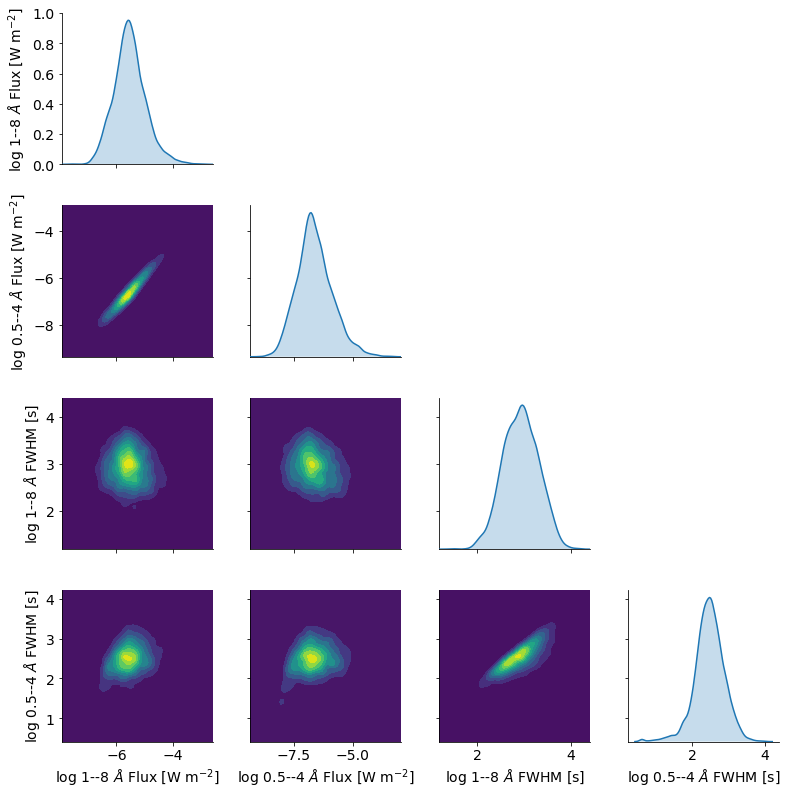

In [8]:
df = DataFrame({'log 1--8 $\AA$ Flux [W m$^{-2}$]':np.log10(data['f2_18']),
                'log 0.5--4 $\AA$ Flux [W m$^{-2}$]':np.log10(data['f2_054']),
                'log 1--8 $\AA$ FWHM [s]':np.log10(data['fwhm18']),
                'log 0.5--4 $\AA$ FWHM [s]':np.log10(data['fwhm054']),})
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

p = sns.pairplot(df, diag_kind = "kde", kind='kde', height=2.75, )
p = p.map_lower(sns.kdeplot, cmap="viridis", shade=True, )
p.map_upper(hide_current_axis)


Then, plot histograms of the timings

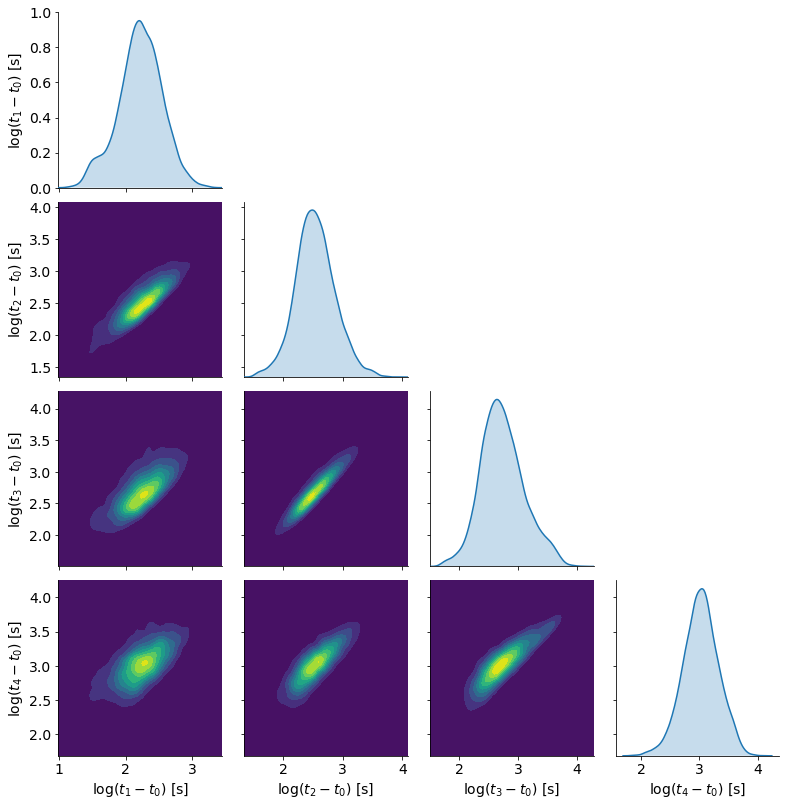

In [9]:
df = DataFrame({r'log($t_{1} - t_{0}$) [s]':np.log10(data['t1_18']-data['t0_18']),
                r'log($t_{2} - t_{0}$) [s]':np.log10(data['t2_18']-data['t0_18']),
                r'log($t_{3} - t_{0}$) [s]':np.log10(data['t3_18']-data['t0_18']),
                r'log($t_{4} - t_{0}$) [s]':np.log10(data['t4_18']-data['t0_18'])})
p = sns.pairplot(df, diag_kind = "kde", kind='kde', height=2.75, )
p = p.map_lower(sns.kdeplot, cmap="viridis", shade=True, )
p.map_upper(hide_current_axis)


## Training a Random Forest--Features up through $t_2$

Now, we create the random forest regressors and train them on the current data.

In the first instance of this, we train using features through time $t_2$ in order to predict both $t_3$ and $t_4$.  

First, create a data matrix for the relevant variables and then do a test-train split.

In [66]:
ind = np.arange(len(data['start_time']))  # This is for selecting out other entries corresponding to the train/test split.
var_names3 = [
    'f0_18', 'f1_18', 'f2_18', 't0_18', 't1_18', 't2_18',
    'a0_18', 'a1_18', 'a2_18', 'dfdt0_18', 'dfdt1_18', 'dfdt2_18',
    'f0_054', 'f1_054', 'f2_054', 't0_054', 't1_054', 't2_054',
    'a0_054', 'a1_054', 'a2_054', 'dfdt0_054', 'dfdt1_054', 'dfdt2_054',
]
features3 = np.array([data[v] for v in var_names3]).T
labels3 = np.array([data['t3_18'], data['t4_18'], data['t3_054'], data['t4_054']]).T

In [67]:
# change random_state = None for truly random splits.
train_features, test_features, train_labels, test_labels, train_ind, test_ind = train_test_split(
    features3, labels3, ind, test_size = 0.33, random_state = 10)

Finally create and train the random forest.

In [68]:
rf_options = {
    'n_estimators': 1500,
    'max_features': 'auto',
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'max_depth': 10,
    'n_jobs': -1,
}

In [69]:
rf = RandomForestRegressor(**rf_options)

In [70]:
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=1500, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Use the trained forest to predict $t_3$ and $t_4$ from our test data.

In [71]:
predictions = rf.predict(test_features)

And then compute the test error on the predicted times

In [72]:
test_error3 = 1 - rf.score(test_features, test_labels)

In [73]:
print(test_error3)

0.2395799525370209


## Detailed Comparisons with Measured Values

Now, plot the predicted values of $t_3$ and $t_4$ against the measured values. If the random forest works perfectly, the slope should be 1 with little scatter.  We see that the slopes are less than 1 here, indicating that the random forest generally underpredicts the total duration of the events.

In [74]:
#estimator = TheilSenRegressor(random_state=None, n_jobs=-1, max_subpopulation=5e4)
estimator = TheilSenRegressor(random_state=10, n_jobs=-1, max_subpopulation=5e4)

In [75]:
x_plot = np.linspace(np.log10(test_labels[:,0].min()), np.log10(test_labels[:,0].max()))
estimator.fit(np.log10(test_labels[:,[0]]),np.log10(predictions[:,[0]]))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

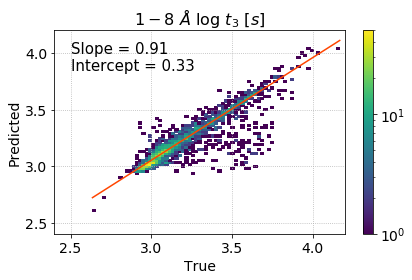

In [76]:
plt.hist2d(np.log10(test_labels[:,0]),np.log10(predictions[:,0]),bins=75,norm=LogNorm())
plt.plot(x_plot,y_plot,color='orangered')
plt.text(2.5,4.0,'Slope = %.2f' %(slope18),fontsize=15)
plt.text(2.5,3.85,'Intercept = %.2f' %(int18),fontsize=15)
plt.xlabel(r'True')
plt.ylabel(r'Predicted')
plt.title(r'$1-8\ \AA\ \log\ t_{3}\ [s]$')
plt.xlim(2.4,4.2)
plt.ylim(2.4,4.2)
plt.tight_layout()
plt.grid(True,which='major',axis='both')
plt.colorbar()

In [77]:
x_plot = np.linspace(np.log10(test_labels[:,1].min()), np.log10(test_labels[:,1].max()))
estimator.fit(np.log10(test_labels[:,1].reshape(-1,1)),np.log10(predictions[:,1].reshape(-1,1)))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

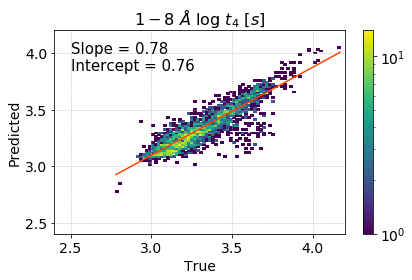

In [78]:
plt.hist2d(np.log10(test_labels[:,1]),np.log10(predictions[:,1]),bins=75,norm=LogNorm())
plt.plot(x_plot,y_plot,color='orangered')
plt.text(2.5,4.0,'Slope = %.2f' %(slope18),fontsize=15)
plt.text(2.5,3.85,'Intercept = %.2f' %(int18),fontsize=15)
plt.xlabel(r'True',)
plt.ylabel(r'Predicted',)
plt.title(r'$1-8\ \AA\ \log\ t_{4}\ [s]$',)
plt.xlim(2.4,4.2)
plt.ylim(2.4,4.2)
plt.tight_layout()
plt.grid(True,which='major',axis='both',)
plt.colorbar()

In [79]:
x_plot = np.linspace(np.log10(test_labels[:,2].min()), np.log10(test_labels[:,2].max()))
estimator.fit(np.log10(test_labels[:,2].reshape(-1,1)),np.log10(predictions[:,2].reshape(-1,1)))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

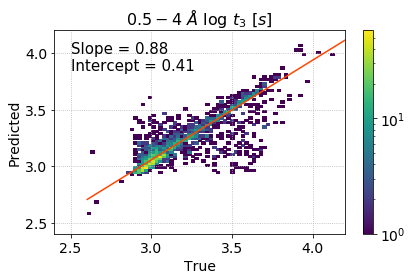

In [80]:
plt.hist2d(np.log10(test_labels[:,2]),np.log10(predictions[:,2]),bins=75,norm=LogNorm())
plt.plot(x_plot,y_plot,color='orangered')
plt.text(2.5,4.0,'Slope = %.2f' %(slope18),fontsize=15)
plt.text(2.5,3.85,'Intercept = %.2f' %(int18),fontsize=15)
plt.xlabel(r'True',)
plt.ylabel(r'Predicted',)
plt.title(r'$0.5-4\ \AA\ \log\ t_{3}\ [s]$',)
plt.xlim(2.4,4.2)
plt.ylim(2.4,4.2)
plt.tight_layout()
plt.grid(True,which='major',axis='both',)
plt.colorbar()

In [81]:
x_plot = np.linspace(np.log10(test_labels[:,3].min()), np.log10(test_labels[:,3].max()))
estimator.fit(np.log10(test_labels[:,3].reshape(-1,1)),np.log10(predictions[:,3].reshape(-1,1)))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

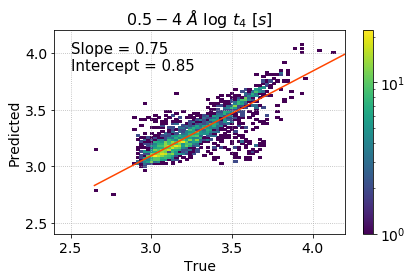

In [82]:
plt.hist2d(np.log10(test_labels[:,3]),np.log10(predictions[:,3]),bins=75,norm=LogNorm())
plt.plot(x_plot,y_plot,color='orangered')
plt.text(2.5,4.0,'Slope = %.2f' %(slope18),fontsize=15)
plt.text(2.5,3.85,'Intercept = %.2f' %(int18),fontsize=15)
plt.xlabel(r'True',)
plt.ylabel(r'Predicted',)
plt.title(r'$0.5-4\ \AA\ \log\ t_{4}\ [s]$',)
plt.xlim(2.4,4.2)
plt.ylim(2.4,4.2)
plt.tight_layout()
plt.grid(True,which='major',axis='both',)
plt.colorbar()

## Training a Random Forest--Features up through $t_3$

Next, we repeat this calculation, except that we use the values through time t3 to predict t4.

In [83]:
var_names4 = [
    'f0_18', 'f1_18', 'f2_18', 'f3_18',
    't0_18', 't1_18', 't2_18', 't3_18',
    'a0_18', 'a1_18', 'a2_18', 'a3_18',
    'dfdt0_18', 'dfdt1_18', 'dfdt2_18', 'dfdt3_18',
    'f0_054', 'f1_054', 'f2_054', 'f3_054',
    't0_054', 't1_054', 't2_054', 't3_054',
    'a0_054', 'a1_054', 'a2_054', 'a3_054',
    'dfdt0_054', 'dfdt1_054', 'dfdt2_054', 'dfdt3_054',
]
features3_t3 = np.array([data[v] for v in var_names4]).T
labels3_t3 = np.array([data['t4_18'], data['t4_054']]).T

In [84]:
train_features_t3, test_features_t3, train_labels_t3, test_labels_t3, train_ind_t3, test_ind_t3= train_test_split(
    features3_t3, labels3_t3, ind, test_size = 0.33, random_state = 10)

In [85]:
rf_t3 = RandomForestRegressor(**rf_options)

In [86]:
rf_t3.fit(train_features_t3, train_labels_t3);

In [87]:
predictions_t3 = rf_t3.predict(test_features_t3)

In [88]:
print(1 - rf_t3.score(test_features_t3, test_labels_t3))

0.05349525834754143


Unsurprisingly, the error here is significantly lower when we add $t_3$ to our training data.

Similarly, plot the true vs predicted values of $t_4$ in each GOES/XRS channel.  In this case, we find that the slopes are much closer to 1, indicating that the prediction is much improved, although it still slightly underestimates duration in general.

In [89]:
estimator = TheilSenRegressor(random_state=10, n_jobs=-1, max_subpopulation=5e4)

In [90]:
x_plot = np.linspace(np.log10(test_labels_t3[:,0].min()), np.log10(test_labels_t3[:,0].max()))
estimator.fit(np.log10(test_labels_t3[:,0].reshape(-1,1)),np.log10(predictions_t3[:,0].reshape(-1,1)))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

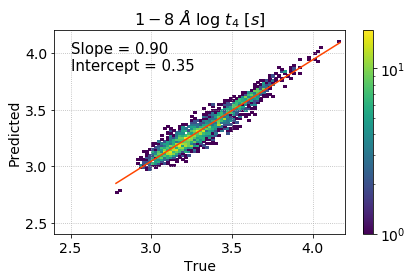

In [91]:
plt.hist2d(np.log10(test_labels_t3[:,0]),np.log10(predictions_t3[:,0]),bins=75,norm=LogNorm())
plt.plot(x_plot,y_plot,color='orangered')
plt.text(2.5,4.0,'Slope = %.2f' %(slope18),fontsize=15)
plt.text(2.5,3.85,'Intercept = %.2f' %(int18),fontsize=15)
plt.xlabel(r'True',)
plt.ylabel(r'Predicted',)
plt.title(r'$1-8\ \AA\ \log\ t_{4}\ [s]$',)
plt.xlim(2.4,4.2)
plt.ylim(2.4,4.2)
plt.tight_layout()
plt.grid(True,which='major',axis='both',linestyle=':')
plt.colorbar()

In [92]:
x_plot = np.linspace(np.log10(test_labels_t3[:,1].min()), np.log10(test_labels_t3[:,1].max()))
estimator.fit(np.log10(test_labels_t3[:,1].reshape(-1,1)),np.log10(predictions_t3[:,1].reshape(-1,1)))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

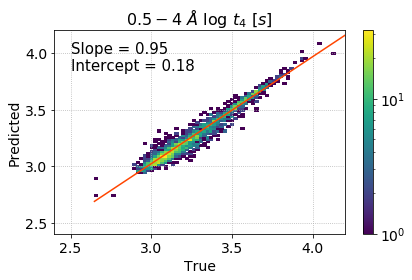

In [93]:
plt.hist2d(np.log10(test_labels_t3[:,1]),np.log10(predictions_t3[:,1]),bins=75,norm=LogNorm())
plt.plot(x_plot,y_plot,color='orangered')
plt.text(2.5,4.0,'Slope = %.2f' %(slope18),fontsize=15)
plt.text(2.5,3.85,'Intercept = %.2f' %(int18),fontsize=15)
plt.xlabel(r'True',)
plt.ylabel(r'Predicted')
plt.title(r'$0.5-4\ \AA\ \log\ t_{4}\ [s]$')
plt.xlim(2.4,4.2)
plt.ylim(2.4,4.2)
plt.tight_layout()
plt.grid(True,which='major',axis='both',)
plt.colorbar()

## Predicting $t_4$ via Linear Regression

Calculate the regression using a linear fit to predict $t_4$. That is, we assume $t_4 \sim t_2$, fit a line, and the calculate a prediction for $t_4$ using $t_2$ alone.  This prediction will then be used to estimate a skill score for the random forest against this simple model.

**Note:** we fit $(t_4-t_0)$ vs $(t_2-t_0)$ because $t_0$ is not set to zero in the data set.

First in the 1-8 Å channel

In [94]:
t2_18_mod = data['t2_18'] - data['t0_18']
t4_18_mod = data['t4_18'] - data['t0_18']
x_plot = np.linspace(np.log10(t2_18_mod[train_ind[:]].min()), np.log10(t2_18_mod[train_ind[:]].max()))
estimator.fit(np.log10(t2_18_mod[train_ind[:]].reshape(-1,1)),np.log10(t4_18_mod[train_ind[:]].reshape(-1,1)))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

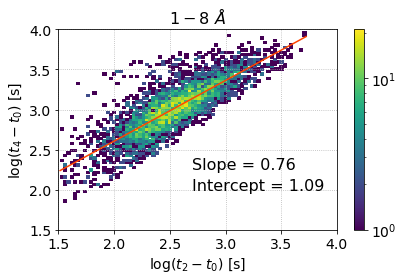

In [95]:
plt.hist2d(np.log10(t2_18_mod[train_ind[:]]),np.log10(t4_18_mod[train_ind[:]]),bins=75,norm=LogNorm())
plt.plot(x_plot,y_plot,color='orangered')
plt.text(2.7,2.25,'Slope = %.2f' %(slope18),fontsize=16)
plt.text(2.7,2.0,'Intercept = %.2f' %(int18),fontsize=16)
plt.xlabel(r'$\log(t_{2} - t_{0})$ [s]',)
plt.ylabel(r'$\log(t_{4} - t_{0})$ [s]',)
plt.xlim(1.5,4.0)
plt.ylim(1.5,4.0)
plt.title(r'$1-8\ \AA$',)
plt.grid(True,which='major',axis='both',)
plt.tight_layout()
plt.colorbar()

And then in the 0.5-4 Å channel

In [96]:
t2_054_mod = data['t2_054'] - data['t0_054']
t4_054_mod = data['t4_054'] - data['t0_054']
x_plot = np.linspace(np.log10(t2_054_mod[train_ind[:]].min()), np.log10(t2_054_mod[train_ind[:]].max()))
estimator.fit(np.log10(t2_054_mod[train_ind[:]].reshape(-1,1)),np.log10(t4_054_mod[train_ind[:]].reshape(-1,1)))
y_plot = estimator.coef_ * x_plot + estimator.intercept_
slope054 = estimator.coef_[0]
int054 = estimator.intercept_

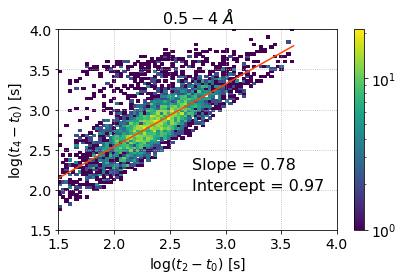

In [97]:
plt.hist2d(np.log10(t2_054_mod[train_ind[:]]),np.log10(t4_054_mod[train_ind[:]]),bins=75,norm=LogNorm())
plt.plot(x_plot,y_plot,color='orangered')
plt.text(2.7,2.25,'Slope = %.2f' %(slope054),fontsize=16)
plt.text(2.7,2.0,'Intercept = %.2f' %(int054),fontsize=16)
plt.xlabel(r'$\log(t_{2} - t_{0})$ [s]',)
plt.ylabel(r'$\log(t_{4} - t_{0})$ [s]',)
plt.xlim(1.5,4.0)
plt.ylim(1.5,4.0)
plt.title(r'$0.5-4\ \AA$',)
plt.grid(True,which='major',axis='both',)
plt.tight_layout()
plt.colorbar()

## Comparing the Random Forest and Linear Regression Predictions

How do these predictions from the random forest fare?  We compute a skill score to check the forecast now, using the simple linear regression as the reference model. 

For each channel, we calculate the mean-squared error of the predicted vs true $t_4$ values, both from the random forest and the linear regression.  The skill score is then defined as,

$$
\mathrm{SS} = 1 - \frac{\mathrm{MSE}_{rf}}{\mathrm{MSE}_{linear}}.
$$

A skill score of 1 is a perfect prediction, between 0 and 1 the random forest outperforms the linear regression, 0 that each model performs equally well, and a negative value means that the linear regression outperforms the random forest.

We finally calculate the skill score for both cases, where we have trained the data (1) through time $t_2$

In [98]:
print("Case 1: RF trained with values through time t2.")
mse18 = np.mean((test_labels[:,1]-predictions[:,1])**2.)
ref_t4 = 10.0**(int18) * (t2_18_mod[test_ind[:]])**(slope18) + data['t0_18'][test_ind[:]]
ref18 = np.mean((test_labels[:,1]-ref_t4[:])**2.)
print(f"Skill score in the 1--8 Angstrom channel: {1 - mse18/ref18}")
mse054 = np.mean((test_labels[:,3]-predictions[:,3])**2.)
ref_t4 = 10.0**(int054) * (t2_18_mod[test_ind[:]])**(slope054) + data['t0_054'][test_ind[:]]
ref054 = np.mean((test_labels[:,3]-ref_t4[:])**2.)
#print(ref054, mse054)
print("Skill score in the 0.5--4 Angstrom channel:", 1 - mse054/ref054)

Case 1: RF trained with values through time t2.
Skill score in the 1--8 Angstrom channel: 0.05248535192736936
Skill score in the 0.5--4 Angstrom channel: 0.21548022213457563


and (2) through time $t_3$.

In [99]:
print("Case 2: RF trained with values through time t3.")
mse18 = np.mean((test_labels_t3[:,0]-predictions_t3[:,0])**2.)
ref_t4 = 10.0**(int18) * (t2_18_mod[test_ind[:]])**(slope18) + data['t0_18'][test_ind[:]]
ref18 = np.mean((test_labels[:,1]-ref_t4[:])**2.)
print("Skill score in the 1--8 Angstrom channel:", 1 - mse18/ref18)
mse054 = np.mean((test_labels_t3[:,1]-predictions_t3[:,1])**2.)
ref_t4 = 10.0**(int054) * (t2_18_mod[test_ind[:]])**(slope054) + data['t0_054'][test_ind[:]]
ref054 = np.mean((test_labels[:,3]-ref_t4[:])**2.)
print("Skill score in the 0.5--4 Angstrom channel:", 1 - mse054/ref054)

Case 2: RF trained with values through time t3.
Skill score in the 1--8 Angstrom channel: 0.6929236561938017
Skill score in the 0.5--4 Angstrom channel: 0.8837694870310062


As we can see from the skill scores, the random forest slightly outperforms linear regression when trained through time $t_2$, and significantly outperforms linear regression when trained through time $t_3$.

This is generally the case, but if the random seed used in the random forest regressor changes, these values do vary slightly and there are times when the linear regression is better in Case 1, but the random forest is always better in Case 2.